In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import torch
from transformers import AutoTokenizer, AutoModel
import umap.umap_ as umap
import hdbscan

# Sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Utilities
from urllib.parse import urlparse
from sklearn.preprocessing import normalize
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hazembakhshwain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import pandas as pd

# Load the actual CSV
df = pd.read_csv("dummy_data.csv")

# Rename columns for consistency with pipeline
df = df.rename(columns={
    "visit_time": "timestamp",
    "page_text": "text"
})

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Fill missing titles (optional: fallback to URL path or empty string)
df["title"] = df["title"].fillna("")

# Drop rows with unusable text (e.g. full error messages or NaNs)
df["text"] = df["text"].astype(str)
df = df[~df["text"].str.contains("404 Client Error", na=False)]
df = df[df["text"].str.strip().astype(bool)]
#  crop df to first 100 rows 
df = df.head(100)

# Display preview
df[["timestamp", "url", "title", "text"]].head()

#print size of the DataFrame
print(f"DataFrame size: {df.shape[0]} rows, {df.shape[1]} columns")

DataFrame size: 100 rows, 5 columns


In [3]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

# Load E5 model and tokenizer
model_name = 'intfloat/multilingual-e5-large-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# Format inputs for E5 (prepend instruction)
df["formatted_text"] = df["text"].apply(lambda x: f"query: {x}")

# Pooling function
def average_pool(last_hidden_states, attention_mask):
    masked = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return masked.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# Encode in batches
batch_size = 8
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(df), batch_size), desc="Embedding"):
        batch_texts = df["formatted_text"].iloc[i:i+batch_size].tolist()
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
        output = model(**tokens)
        embeddings = average_pool(output.last_hidden_state, tokens['attention_mask'])
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        all_embeddings.append(embeddings.cpu())

# Combine into single array
embedding_matrix = torch.cat(all_embeddings)
df["embedding"] = list(embedding_matrix.numpy())

Embedding: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


In [11]:
import torch

# Save the full embedding matrix (2D tensor)
torch.save(embedding_matrix, "embeddings.pt")

# Optionally save aligned DataFrame with IDs or metadata
df.to_csv("embedded_df.csv", index=False)

In [4]:
import umap 
import hdbscan

# Step 1: UMAP dimensionality reduction to 15 dimensions
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=15,
    metric='cosine',
    random_state=42
)

embedding_array = np.vstack(df["embedding"].values)
embedding_15d = umap_reducer.fit_transform(embedding_array)

# Step 2: HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric='euclidean',
    prediction_data=True,
    gen_min_span_tree=True
)

cluster_labels = clusterer.fit_predict(embedding_15d)

# Step 3: Assign cluster labels to DataFrame
df["cluster"] = cluster_labels

# Step 4: Print clustering stats
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)

print(f"✅ Clustering Complete")
print(f"Total clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Clustering Complete
Total clusters: 4
Noise points: 0


/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import torch
from transformers import AutoTokenizer, AutoModel
import umap.umap_ as umap
import hdbscan

# Sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Utilities
from urllib.parse import urlparse
from sklearn.preprocessing import normalize
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hazembakhshwain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def extract_top_keywords_c_tf_idf(df, text_col='text', label_col='cluster', top_k=10):
    # Combine texts per cluster
    cluster_texts = (
        df[df[label_col] != -1]  # exclude noise
        .groupby(label_col)[text_col]
        .apply(lambda texts: " ".join(texts))
    )

    # Count Vectorizer
    count_vec = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    count_matrix = count_vec.fit_transform(cluster_texts)

    # Class-based TF-IDF
    tfidf = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
    ctfidf_matrix = tfidf.fit_transform(count_matrix)

    # Extract keywords and build results
    feature_names = count_vec.get_feature_names_out()
    records = []
    for idx, row in enumerate(ctfidf_matrix):
        cluster_id = cluster_texts.index[idx]
        sorted_indices = row.toarray().flatten().argsort()[::-1][:top_k]
        keywords = [feature_names[i] for i in sorted_indices]
        count = df[df[label_col] == cluster_id].shape[0]
        records.append({
            "cluster": cluster_id,
            "keywords": ", ".join(keywords),
            "count": count
        })

    results = pd.DataFrame(records).sort_values("count", ascending=False).reset_index(drop=True)
    return results

cluster_summary = extract_top_keywords_c_tf_idf(df)
display(cluster_summary)
    

,cluster,keywords,count
0,3,"apps, mcp, build, security, code, search, even...",39
1,0,"add, info, real, london, 50, order, google, se...",27
2,1,"view, mcp, file, reload, external, changes, de...",25
3,2,"english, email, português, español, united, fr...",9


In [7]:
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate

def label_clusters_with_ollama_df(summary_df, model_name="gemma3:4b"):
    """
    Add a 'label' column to a cluster summary DataFrame using a local Ollama model via LangChain.

    Args:
        summary_df (pd.DataFrame): DataFrame with 'cluster' and 'keywords' columns.
        model_name (str): Name of the Ollama model to use (default: 'gemma3:4b').

    Returns:
        pd.DataFrame: The input DataFrame with an added 'label' column.
    """
    llm = Ollama(model=model_name)

    prompt_template = PromptTemplate.from_template(
        "You are helping categorize clusters of search history topics.\n"
        "Given the following top keywords, generate a short and specific label "
        "that summarizes the main idea of the cluster using 2–4 words. Avoid vague or generic terms.\n\n"
        "Keywords: {keywords}\n"
        "Label:"
    )

    labels = []
    for _, row in summary_df.iterrows():
        prompt = prompt_template.format(keywords=row["keywords"])
        try:
            label = llm.invoke(prompt).strip()
        except Exception as e:
            print(f"❌ Error generating label for cluster {row['cluster']}: {e}")
            label = "Unknown"
        labels.append(label)

    summary_df = summary_df.copy()
    summary_df["label"] = labels
    return summary_df

cluster_summary = extract_top_keywords_c_tf_idf(df)
cluster_summary = label_clusters_with_ollama_df(cluster_summary)
display(cluster_summary)

/var/folders/nb/sl7m1pjj2td7wjhc_nfnp9c80000gn/T/ipykernel_6590/811380651.py:15: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model=model_name)


,cluster,keywords,count,label
0,3,"apps, mcp, build, security, code, search, even...",39,App Development Issues
1,0,"add, info, real, london, 50, order, google, se...",27,London Restaurant Info
2,1,"view, mcp, file, reload, external, changes, de...",25,MCP File Changes
3,2,"english, email, português, español, united, fr...",9,Multilingual Web Development


/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hazembakhshwain/miniconda3/envs/IRP/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


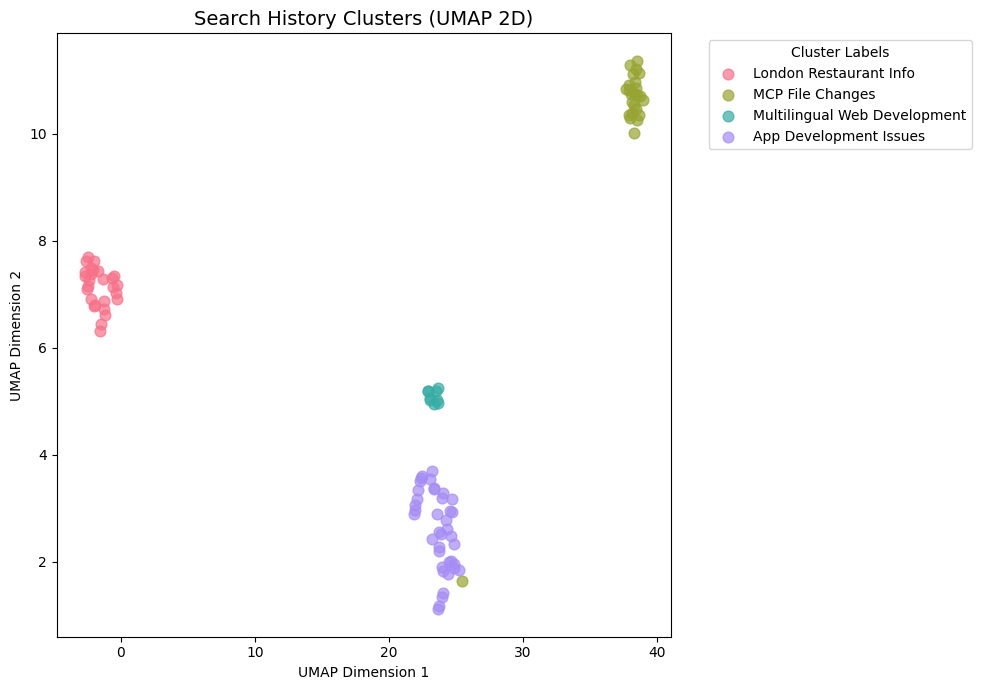

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

# Step 1: UMAP to 2D
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
embedding_2d = umap_2d.fit_transform(embedding_array)

df["x_2d"] = embedding_2d[:, 0]
df["y_2d"] = embedding_2d[:, 1]

# Step 2: Create cluster-to-label map from the cluster summary DataFrame
label_map = dict(zip(cluster_summary["cluster"], cluster_summary["label"]))
df["cluster_label"] = df["cluster"].apply(lambda cid: label_map.get(cid, "Noise") if cid != -1 else "Noise")

# Step 3: Color palette
unique_clusters = sorted(df["cluster"].unique())
palette = sns.color_palette("husl", len(unique_clusters))
cluster_color_map = {cid: palette[i] for i, cid in enumerate(unique_clusters)}

# Step 4: Plot
plt.figure(figsize=(10, 7))
for cid in unique_clusters:
    subset = df[df["cluster"] == cid]
    label = label_map.get(cid, "Noise") if cid != -1 else "Noise"
    plt.scatter(subset["x_2d"], subset["y_2d"], s=60, label=label, color=cluster_color_map[cid], alpha=0.7)

plt.title("Search History Clusters (UMAP 2D)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

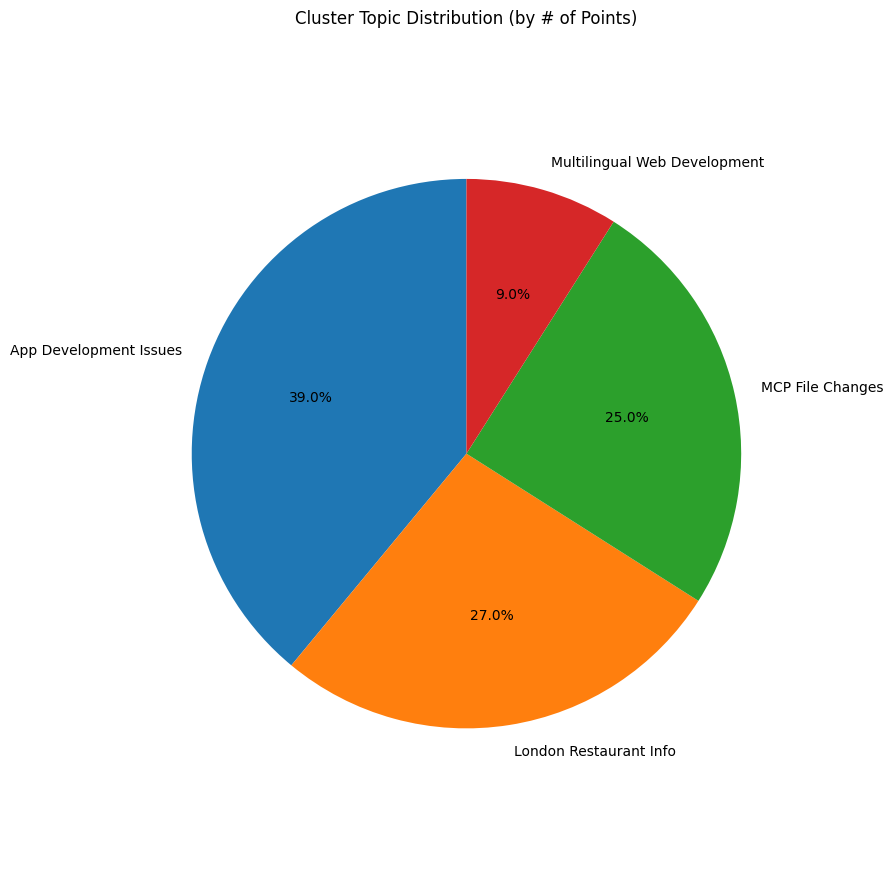

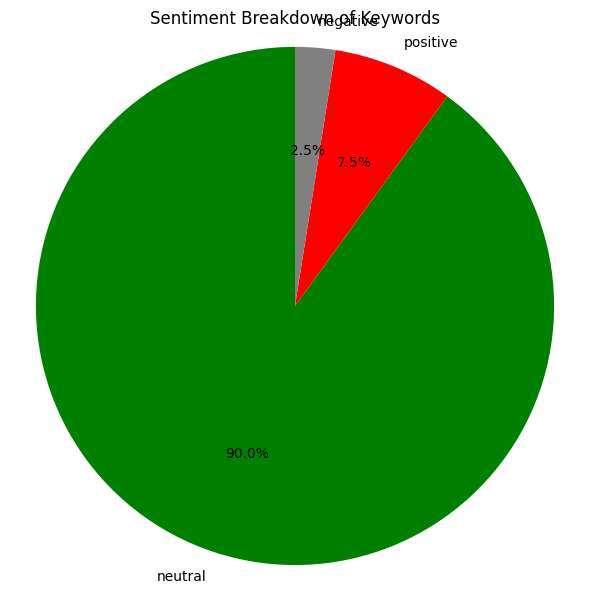


 Sentiment Bubble Detected: 'NEUTRAL' dominates 90% of all keywords.

Info: NEUTRAL sentiment dominates 90% of all keywords.

Keyword Sentiment Summary:
Neutral: 36 keywords
Positive: 3 keywords
Negative: 1 keywords


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import matplotlib.pyplot as plt

# === Step 1: Parse cluster topics and keywords ===
def extract_clusters_from_df(df):
    clusters = []
    for _, row in df.iterrows():
        cluster = {
            "topic": row["label"],
            "keywords": [kw.strip().lower() for kw in row["keywords"].split(",")],
            "num_points": row["count"]
        }
        clusters.append(cluster)
    return clusters

# === Step 2: Extract all keywords across all clusters ===
def extract_all_keywords(clusters):
    return [kw for cluster in clusters for kw in cluster["keywords"]]

# === Step 3: Sentiment classification ===
analyser = SentimentIntensityAnalyzer()

def classify_word_sentiment(word):
    score = analyser.polarity_scores(word)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

def classify_all_keywords(keywords):
    return [classify_word_sentiment(word) for word in keywords]

# === Step 4: Sentiment pie chart ===
def plot_keyword_sentiment_pie(sentiments):
    counts = Counter(sentiments)
    labels = counts.keys()
    sizes = counts.values()
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=["green", "red", "grey"])
    plt.title("Sentiment Breakdown of Keywords")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# === Step 5: Topic distribution pie chart ===
def plot_topic_names(clusters):
    topic_counts = {c["topic"]: c["num_points"] for c in clusters}
    sorted_topics = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(9, 9))
    plt.pie(sorted_topics.values(), labels=sorted_topics.keys(), autopct='%1.1f%%', startangle=90)
    plt.title("Cluster Topic Distribution (by # of Points)")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# === Step 6: Sentiment bubble detection ===
def detect_sentiment_bubble(sentiments, threshold=0.7):
    counts = Counter(sentiments)
    total = len(sentiments)
    for sentiment, count in counts.items():
        if count / total > threshold:
            print(f"\n Sentiment Bubble Detected: '{sentiment.upper()}' dominates {int(count / total * 100)}% of all keywords.")

def detect_sentiment_warnings(sentiments, threshold=0.6):
    counts = Counter(sentiments)
    total = len(sentiments)

    for sentiment, count in counts.items():
        percentage = count / total
        if percentage > threshold:
            if sentiment == "negative":
                print(f"\nWarning: NEGATIVE sentiment dominates {int(percentage * 100)}% of all keywords.")
            elif sentiment == "positive":
                print(f"\nHeads up: POSITIVE sentiment dominates {int(percentage * 100)}% of all keywords.")
            elif sentiment == "neutral":
                print(f"\nInfo: NEUTRAL sentiment dominates {int(percentage * 100)}% of all keywords.")

# === Run the full analysis ===
clusters = extract_clusters_from_df(cluster_summary)
all_keywords = extract_all_keywords(clusters)
keyword_sentiments = classify_all_keywords(all_keywords)

plot_topic_names(clusters)
plot_keyword_sentiment_pie(keyword_sentiments)
detect_sentiment_bubble(keyword_sentiments)
detect_sentiment_warnings(keyword_sentiments)

print("\nKeyword Sentiment Summary:")
for s, count in Counter(keyword_sentiments).items():
    print(f"{s.capitalize()}: {count} keywords")